In [35]:
import numpy as np
import scipy.sparse as sparse
from os import listdir
import matplotlib.pyplot as plt

In [45]:


chroms = [str(x) for x in range(1, 23)]
#data_dir = '../split_gen_ihart'
data_dir = '../split_gen_spark'
ped_file = '../data/spark.ped'

# read samples
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, '10')
with open(sample_file, 'r') as f:
    sample_id_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])

# read family structure
parents = set()
children = set()
with open(ped_file, 'r') as f:
    for line in f:
        fam_id, ind_id, dad_id, mom_id, sex, disease_status = line.strip().split('\t')[:6]
        # sex: 1=male, 2=female
        # disease status: 1=unaffected, 2=affected
        if dad_id != '0' and dad_id in sample_id_to_index:
            parents.add(dad_id)
        if mom_id != '0' and mom_id in sample_id_to_index:
            parents.add(mom_id)
        if (dad_id != '0' or mom_id != '0') and ind_id in sample_id_to_index:
            children.add(ind_id)
        
# only interested in children, not parents
samples_of_interest = sorted(children | parents)
indices = [sample_id_to_index[s] for s in samples_of_interest]
print('Individuals of interest:', len(indices))

all_gen_data = []
all_positions = []
for chrom in chroms:
    print(chrom)
    
    # load genotypes
    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

    # pull snp positions
    pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
    is_snp = pos_data[:, 2].astype(bool)
    is_pass = pos_data[:, 3].astype(bool)
    #is_pass = np.ones(is_snp.shape, dtype=bool)
    snp_positions = pos_data[:, 1]
    print('Sites pulled from vcf:', snp_positions.shape[0])

    # pull PASS (from GATK)
    #is_pass = np.load('%s/chr.%s.pass.npy' % (data_dir, chrom))

    # Pull data together
    A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices, :] for gen_file in gen_files])

    # only look at snps that PASS GATK filter
    A = A[:, is_snp & is_pass]
    snp_positions = snp_positions[is_snp & is_pass]
    print('Removed %d sites that are not bi-allelic SNPs' % np.sum(~is_snp))
    print('Removed %d sites that do not pass GATK' % np.sum(is_snp & ~is_pass))

    # sparse to dense
    A = A.A

    # filter out sites with too many missing values
    missing_cutoff = 0.01
    lots_of_missing_indices = np.sum(A<0, axis=0) > 0.01*len(indices)
    #A = A[:, ~lots_of_missing_indices]
    #snp_positions = snp_positions[~lots_of_missing_indices]
    print('Removed %d sites with >%0.3f missing' % (np.sum(lots_of_missing_indices), missing_cutoff))

    # remove sites where everyone is homref or missing
    has_variants = np.any(A>0, axis=0)
    #A = A[:, has_variants]
    #snp_positions = snp_positions[has_variants]
    print('Removed %d sites where everyone is hom-ref' % np.sum(~has_variants))

    # remaining missing -> hom ref
    #print('Changed %d calls from missing (-1) to hom-ref (0)' % np.sum(A<0))
    #A[A<0] = 0

    print('Final matrix', A.shape, snp_positions.shape)
    
    all_gen_data.append(A)
    all_positions.append(snp_positions)


Individuals of interest: 13249
1
Sites pulled from vcf: 49076
Removed 455 sites that are not bi-allelic SNPs
Removed 48621 sites that do not pass GATK
Removed 0 sites with >0.010 missing
Removed 0 sites where everyone is hom-ref
Final matrix (13249, 0) (0,)
2
Sites pulled from vcf: 51804
Removed 789 sites that are not bi-allelic SNPs
Removed 51015 sites that do not pass GATK
Removed 0 sites with >0.010 missing
Removed 0 sites where everyone is hom-ref
Final matrix (13249, 0) (0,)
3
Sites pulled from vcf: 43164
Removed 485 sites that are not bi-allelic SNPs
Removed 42679 sites that do not pass GATK
Removed 0 sites with >0.010 missing
Removed 0 sites where everyone is hom-ref
Final matrix (13249, 0) (0,)
4
Sites pulled from vcf: 39709
Removed 248 sites that are not bi-allelic SNPs
Removed 39461 sites that do not pass GATK
Removed 0 sites with >0.010 missing
Removed 0 sites where everyone is hom-ref
Final matrix (13249, 0) (0,)
5
Sites pulled from vcf: 37315
Removed 434 sites that are not

In [11]:
gen_files = sorted([f for f in listdir('../split_gen_ihart') if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

A = sparse.hstack([sparse.load_npz('%s/%s' % ('../split_gen_ihart', gen_file))[indices, :] for gen_file in gen_files])
B = sparse.hstack([sparse.load_npz('%s/%s' % ('../split_gen_ihart_new', gen_file))[indices, :] for gen_file in gen_files])


In [12]:
print(A.shape, B.shape)

(2700, 1096535) (2700, 1096535)


In [19]:
print(np.all(A.nnz==B.nnz))

True


In [8]:
print(all_positions[0].shape)

(2965432,)


In [15]:
gen_data = np.hstack(all_gen_data)
positions = np.hstack(all_positions)
print(gen_data.shape, positions.shape)

(13249, 607427) (607427,)


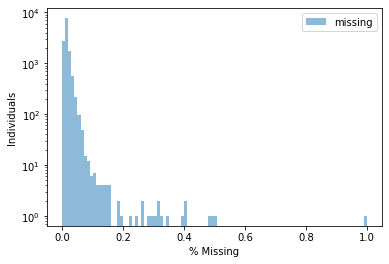

In [16]:
num_missing = np.sum(gen_data<0, axis=1)/gen_data.shape[1]
plt.hist(num_missing, log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5, label='missing')

plt.legend()
plt.xlabel('% Missing')
plt.ylabel('Individuals')
plt.show()

In [38]:
homalt = np.sum(gen_data==2, axis=0)
het = np.sum(gen_data==1, axis=0)
miss = np.sum(gen_data<0, axis=0)

In [39]:
af = (2*homalt + het)/(2*gen_data.shape[0] - 2*miss)
percent_miss = miss/gen_data.shape[0]

In [40]:
print(np.sum(af < 0.01)/af.shape[0])
print(np.sum(percent_miss >= 0.01)/af.shape[0])
print(np.sum(percent_miss >= 0.01)/af.shape[0])

0.18771309144967213
0.19342571206087317


In [41]:
is_pass = (af >= 0.01) & (percent_miss < 0.01)
print(np.sum(~is_pass)/af.shape[0])

0.3544952726829726


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


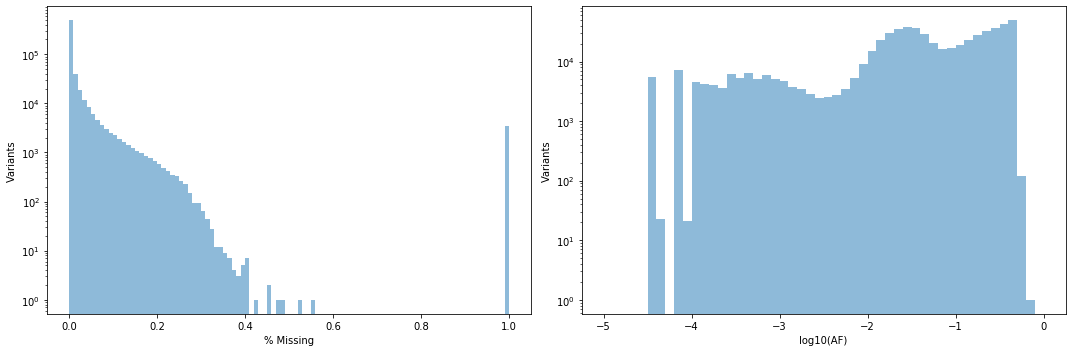

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(miss/gen_data.shape[0], log=True, bins=np.arange(0, 1.01, 0.01), alpha=0.5)
plt.xlabel('% Missing')
plt.ylabel('Variants')

plt.subplot(1, 2, 2)
af = (2*homalt + het)/(2*gen_data.shape[0] - 2*miss)
plt.hist(np.log10(af), log=True, alpha=0.5, bins=np.arange(-5, 0.1, 0.1))
plt.xlabel('log10(AF)')
plt.ylabel('Variants')

plt.tight_layout()
plt.show()

In [14]:
with open('../data/OMNI2.5_pruned_positions.txt', 'w+') as outf:
    outf.write('# rsid\tchromosome\tposition\n')
    for chrom in [str(x) for x in range(1, 23)]:
        with open('../../PrunediHART/%s.pruned.bim' % chrom) as f:
            for line in f:
                pieces = line.strip().split('\t')
                outf.write('.\t%s\t%s\n' % (chrom, pieces[3]))
    

In [29]:
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])
A = A[:, is_snp]

# AF filter
homalt = (A==2).sum(axis=0).A.flatten()
het = (A==1).sum(axis=0).A.flatten()
miss = (A<0).sum(axis=0).A.flatten()
af = (2*homalt + het)/(2*gen_data.shape[0] - 2*miss)

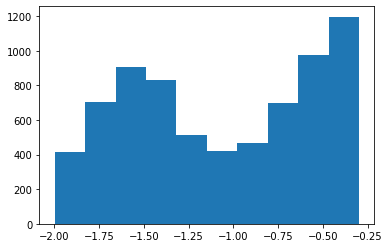

In [32]:
plt.hist(np.log10(af[af>0.01]))
plt.show()

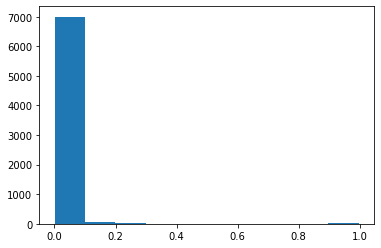

In [34]:
plt.hist(miss[af>0.01]/A.shape[0])
plt.show()

In [42]:
print(A.shape)

(13249, 13725)
